In [1]:
import energym
from scipy import signal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as so
import gurobipy

import pyomo
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from pyomo.environ import *
import time 

from pyomo.opt import SolverStatus, TerminationCondition

In [2]:
weather = "CH_VD_Lausanne"
env = energym.make("SimpleHouseRad-v0", weather=weather, simulation_days=10)

outputs = env.get_output()
outputs["temRoo.T"]

the initial variables are {'u': 0.0}


293.15

In [3]:

# for generating training data
steps = 288*5
out_list = []
outputs = env.get_output()
controls = []
hour = 0
hours = []
for i in range(steps):
    control = {}
    control['u'] = [0.5*(np.sin(i * 0.1 + np.random.rand()) + 1)]
    controls +=[ {p:control[p][0] for p in control} ] # each element is a dictionary
    outputs = env.step(control)
    _,hour,_,_ = env.get_date()
    hours.append(hour)
    out_list.append(outputs)
    
    
out_df = pd.DataFrame(out_list)
in_df = pd.DataFrame(controls)

[OK] %s
[WARNING] %s


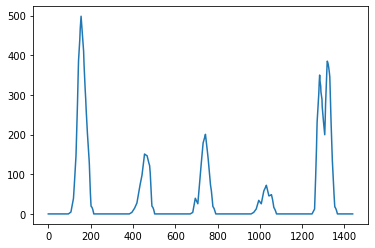

In [4]:
plt.plot(out_df["sunRad.y"].values)

In [5]:
##################################################
###    solar power prediction
##################################################

def solar_predict(S_DNI, S_DHI, Ta):
    Am = 0
    theta_m = 28/360 * 2* np.pi
    As = 265/360*2*np.pi
    a_s = 30/360*2*np.pi
    lamb = -0.0038
    T_NOCT = 45
    Pr = 327
    
    Sm_DNI = S_DNI*(np.sin(theta_m) * np.cos(a_s) * np.cos(Am - As) + np.cos(theta_m) * np.sin(a_s))
    Sm_DHI = S_DHI*(1+ np.cos(theta_m))/2
    Sm = Sm_DHI + Sm_DNI 
    
    T_cell = Ta + Sm/800*(T_NOCT - 20)
    P_m = Pr*Sm/1000*(1 - lamb*(T_cell - 25))
    
    return P_m


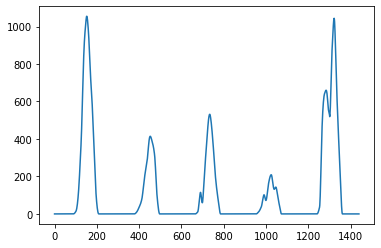

In [6]:
##################################################
###  whether data generation
##################################################
S_DNI = out_df["weaBus.HDirNor"].values
S_DHI = out_df["weaBus.HDifHor"].values
T_out = out_df["TOut.T"].values

P_m = solar_predict(S_DNI, S_DHI, T_out)*1500/327 ## solar power is scaled to 5000 w

plt.plot(P_m)    

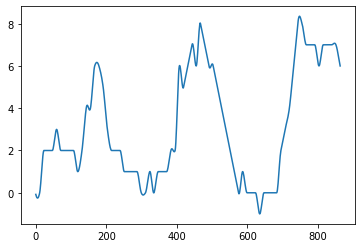

In [7]:
plt.plot(T_out[:288*3] - 273.15)

In [8]:
######################################################################
##  cop_predict: optimize a constant COP via LAE (with rad.Q and u)
######################################################################

rad_Q = -out_df["rad.Q_flow"].values
u = in_df["u"].values 

def cop_predict(x):
    res = np.zeros(len(rad_Q))
    for i in range(len(rad_Q)):
        res[i] = np.abs(rad_Q[i] - u[i]*x*5000)
    return res

result = so.least_squares(cop_predict, 4)
result.x

array([3.48229887])

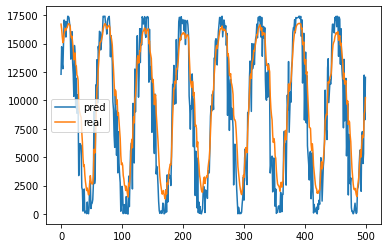

In [9]:
plt.figure() 
plt.plot((result.x*u*5000)[:500])
plt.plot(rad_Q[:500])
plt.legend(["pred","real"])

[4.38971827]


4341072.800496586

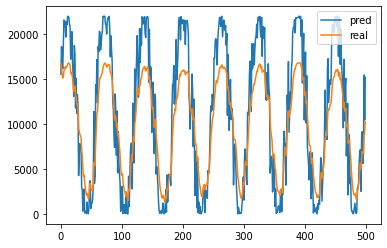

In [10]:
###################################################
#### fit a constant COP via LS
###################################################
COP_output = out_df["heaPum.COP"].values
def cop_pred(x):
    res = np.zeros(len(COP_output))
    for i in range(len(COP_output)):
        res[i] = np.abs(x - COP_output[i])
    return res

res_COP = so.least_squares(cop_pred, 3)
print(res_COP.x)

plt.figure() 
plt.plot((res_COP.x*u*5000)[:500])
plt.plot(rad_Q[:500])
plt.legend(["pred","real"])

np.sum(np.abs(res_COP.x*u*5000 - rad_Q))

In [11]:
# prepare the input training data (10 days simulation)
train_inputs = np.concatenate((out_df[["TOut.T","rad.Q_flow","sunRad.y"]].values[:2880],in_df["u"].values[:2880].reshape(-1,1)), axis = 1) # add solar irradiation
train_outputs = out_df["y"].values[:2880]
train_inputs.shape

(1440, 4)

In [12]:
# define the RC-circuits evolution of room temperature for so.curve_fit
def simpleRC_full(inputs,Ci,Ri,Ai):
    to = inputs[:,0] # ambient temperature
    heat = inputs[:,1]/-300 # heating flow
    rad = inputs[:,2] # sun Radiation
    hp_input = inputs[:,3]
    dt = 300
    
    ti = np.zeros(len(to))
    ti[0] = train_outputs[0]
    
    for t in range(1,len(to)):
        ti[t] = ti[t-1] + (dt/Ci)*( (to[t-1] - ti[t-1])/Ri + result.x*hp_input[t-1]*5000 + Ai*rad[t-1] )
    return ti

In [13]:
p_opt, p_cov = so.curve_fit(simpleRC_full, xdata = train_inputs, ydata = train_outputs, p0 = [1e6,0.01,5])
res = pd.DataFrame(index = ["Ci","Ri","Ai"])
res["avg"] = p_opt
res["std"] = np.diag(p_cov)**0.5
res

,avg,std
Ci,1.140627e+07,80764.988120
Ri,2.255745e-03,0.000002
Ai,4.880203e+00,0.133427


1.185338317394553

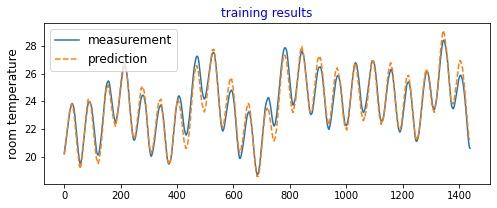

In [14]:
plt.figure(figsize=(8,6.5))
ft = 12
plt.subplot(211)
plt.plot(train_outputs - 273.15)
plt.plot(simpleRC_full(train_inputs,*p_opt) - 273.15,"--")
plt.legend(["measurement","prediction"],fontsize = ft)
#plt.xlabel("time")
plt.ylabel("room temperature",fontsize = ft)
plt.title("training results",fontsize = ft, color = "b")
np.max(np.abs(train_outputs - simpleRC_full(train_inputs,*p_opt)))

In [15]:
dt = 300
Ci = p_opt[0]
Ri  = p_opt[1]
Ai = p_opt[2]
A = np.array(1-(dt/Ci/Ri))

COP = result.x
B1 = np.array(dt/Ci*COP) # input matrix for electricity power
B21 = (dt/Ci/Ri) # input gain for ambient temperature
B22 = (dt/Ci)*Ai # input gain for sun radiation
B2 = np.array([B21, B22]) 
print(f"A, B1, B2 are {A,B1,B2}")

A, B1, B2 are (array(0.9883403), array([9.15890335e-05]), array([0.0116597 , 0.00012836]))


In [16]:
# ###### the results of system parameters and COP
# COP = 3.67
# A = 0.9855513858690267
# B1 = 0.00889877352125733*COP/300  # unscaled power input (0,5000)
# B2 = np.array([0.01444861, 0.00011809])

In [17]:
import pandas as pd
data_frame = pd.read_csv("slow_Price.csv")
price = np.array(data_frame.loc[2,:])
#print(data_frame.loc[0,:])
price = np.repeat(price, 12)
price = price/1e3 # electricity price

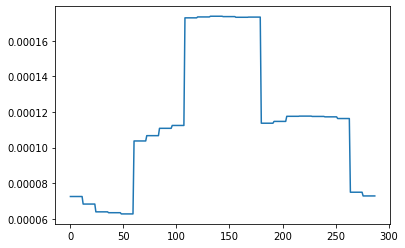

In [18]:
plt.plot(price)

In [ ]:
weather = "CH_VD_Lausanne"
env = energym.make("SimpleHouseRad-v0", weather=weather, simulation_days=1)

In [ ]:
prediction_horizon  = 144
forecast = env.get_forecast(forecast_length = prediction_horizon)
outputs = env.get_output()
ubar = P_m[:prediction_horizon]
##################################################################
### plot the output of wbar and room temp with local RES and without RES
##################################################################
### optimal_control_wbar(ti_0, tem_amb, sun_rad, set_point, price, pre_hori, ubar)

## with RES
w_nominal, x_nominal, u_nominal = optimal_control_wbar(outputs["temRoo.T"], forecast["TOut.T"], forecast["sunRad.y"], 22, price, prediction_horizon, ubar)

## without RES
ubar = np.zeros(prediction_horizon)
w_nominal_zero, x_nominal_zero, u_nominal_zero = optimal_control_wbar(outputs["temRoo.T"], forecast["TOut.T"], forecast["sunRad.y"], 22, price, prediction_horizon, ubar)


In [ ]:
##########################################################
#### plot the nominal power from grid and room temp prediction with and without local RES
##########################################################
plt.subplot(211)
plt.plot(w_nominal)
plt.plot(w_nominal_zero)
plt.legend(["with RES", "without RES"])
plt.title("wbar and price signal")
plt.subplot(212)
plt.plot(price)

plt.figure()
plt.subplot(211)
plt.plot(np.array(x_nominal) - 273.15)
plt.plot(np.array(x_nominal_zero) - 273.15)
plt.legend(["with RES", "without RES"])
plt.title("room T and u_RES")
plt.subplot(212)
plt.plot(np.array(u_nominal)) 
plt.plot(np.array(u_nominal_zero))
plt.legend(["with RES", "without RES"])

In [ ]:
weather = "CH_VD_Lausanne"
env = energym.make("SimpleHouseRad-v0", weather=weather, simulation_days=2)
outputs = env.get_output()
outputs["temRoo.T"]

In [ ]:
steps = 287
out_list_nominal = []
outputs_nominal = env.get_output()
out_list_nominal.append(outputs_nominal)
print(outputs_nominal["temRoo.T"])
controls_nominal = []
hours = []

for i in range(steps):
    control = {} 
#    forecast = env.get_forecast(forecast_length = pre_hori)
    _u = (w_nominal[i] + u_nominal[i])/5000
    control['u'] = [_u]# + 0.25*(np.sin(i * 0.01 + np.random.rand()) + 1)]
    controls_nominal +=[ {p:control[p][0] for p in control} ] # each element is a dictionary
    outputs_nominal = env.step(control)
    _,hour,_,_ = env.get_date()
    hours.append(hour)
    out_list_nominal.append(outputs_nominal)

In [ ]:
time_hori = np.linspace(0,288,288)/12

out_sim_nominal  = pd.DataFrame(out_list_nominal)

plt.plot(time_hori, out_sim_nominal["temRoo.T"].values - 273.15)
plt.plot(time_hori, np.array(x_nominal) - 273.15)
plt.legend(["real room T", "predicted room T"])


In [ ]:
out_sim_nominal

In [19]:
###############################################################
### prepare the time-lifted matrix
###############################################################

def lifted_matrix(A,B,n,m,N):
    P = np.zeros((n*N,m*N))
    for i in range(N):
        for j in range(N):
                if i>j:
                    Pij = A**(i-j)*B
                elif i == j:
                    Pij = B
                else:
                    Pij = 0

                P[i*n:(i+1)*n,j*m:(j+1)*m] = Pij
    return P

def time_lifted_matrix(N):
    
#     COP = 3.67
#     A = 0.9855513858690267
#     B1 = 0.00889877352125733*COP/300  # unscaled power input (0,5000)
#     B2 = np.array([0.01444861, 0.00011809])
    
#    A = np.array(A) # system matrix
    B = np.array(B1) # input matrix local power energy
    R = B # input matrix for power from grid
    D = B2  # input matrix for external uncontrolled coditions
    n = 1
    m = 1
    p = 2
    Fu = np.zeros((n*N, m*N))
    Fw = np.zeros((n*N, N))
    Fd = np.zeros((n*N, p*N))

    Fu = lifted_matrix(A,B,1,1,N)

    Fw = lifted_matrix(A,B,1,1,N)

    Fd = lifted_matrix(A,D,1,2,N)
    
    return Fu, Fw, Fd
        

def Hw_Hd(N_w, N, p, dH):
    
    H1 = np.eye(N_w)
    H2 = -np.eye(N_w)
    # _H3 = np.zeros((N-1,N))
    # _H3[:,:N-1] += -np.eye(N-1)
    # _H3[:,1:N] += np.eye(N-1)
    # H3 = _H3
    # H4 = -H3

    Hw = np.concatenate((H1,H2),axis = 0)

#    dH = np.array([2, 20]) # dH defines the range of prediction uncertainty: 2 degrees and 20 radiation
#     dH = np.array([5,50])
    Hd = np.concatenate((np.eye(p*N),-np.eye(p*N)), axis = 0)
    beta_value = np.kron(np.ones(2*N),dH)#(beta is predefined in pyomo), np.concatenate((np.kron(-np.ones(N),dH), np.kron(np.ones(N),dH)), axis = 0)
    
    return Hw, Hd, beta_value

In [20]:
lower_bound = 19
upper_bound = 24

In [21]:

def GF_function(N):

    T_lower = lower_bound + 273.15
    T_high = upper_bound + 273.15
        
    n = 1
    m = 1

    Gx = np.concatenate((-np.eye(n*N), np.eye(n*N)),axis = 0)
    gx = np.concatenate((T_lower*np.ones(N),-T_high*np.ones(N)))

    # u_low = np.zeros(N)
    # u_high = np.zeros(N)
    # gu = np.concatenate((u_low, -u_high), axis = 0)

    Gu = np.concatenate((-np.eye(m*N), np.eye(m*N)), axis = 0)

    Fu, Fw, Fd = time_lifted_matrix(N)
    GxFu = np.dot(Gx, Fu)
    GxFw = np.dot(Gx, Fw)
    GxFd = np.dot(Gx, Fd)
    
    return Gx, gx, GxFu, GxFw, GxFd

In [22]:
T_lower = lower_bound + 273.15
T_high = upper_bound + 273.15

N_flexi = 24  ### N is the prediction horizon for making assessment of the flexibility

n = 1
m = 1

Gx = np.concatenate((-np.eye(n*N_flexi), np.eye(n*N_flexi)),axis = 0)
gx = np.concatenate((T_lower*np.ones(N_flexi),-T_high*np.ones(N_flexi)))

# u_low = np.zeros(N)
# u_high = np.zeros(N)
# gu = np.concatenate((u_low, -u_high), axis = 0)

Gu = np.concatenate((-np.eye(m*N_flexi), np.eye(m*N_flexi)), axis = 0)

Fu, Fw, Fd = time_lifted_matrix(N_flexi)
GxFu = np.dot(Gx, Fu)
GxFw = np.dot(Gx, Fw)
GxFd = np.dot(Gx, Fd)

In [23]:
def Hw_Hd_new(N_w, N, p, dH):
    
    H1 = np.eye(N_w)
    H2 = -np.eye(N_w)
    _H3 = np.zeros((N_w-1,N_w))
    _H3[:,:N_w-1] += -np.eye(N_w-1)
    _H3[:,1:N_w] += np.eye(N_w-1)
    H3 = _H3
    H4 = -H3
    # size of Hw is (4N_w - 2, N_w)
    Hw = np.concatenate((H1,H2,H3,H4),axis = 0)

#    dH = np.array([2, 20]) # dH defines the range of prediction uncertainty: 2 degrees and 20 radiation
#     dH = np.array([5,50])
    Hd = np.concatenate((np.eye(p*N),-np.eye(p*N)), axis = 0)
    beta_value = np.kron(np.ones(2*N),dH)#(beta is predefined in pyomo), np.concatenate((np.kron(-np.ones(N),dH), np.kron(np.ones(N),dH)), axis = 0)
    
    return Hw, Hd, beta_value

In [24]:
#####################################
### return matrixes of Lu and Lw
#####################################

def L_function(N):
    _Lu2 = np.zeros((N-1,N))
    _Lu2[:,:N-1] += -np.eye(N-1)
    _Lu2[:,1:] += np.eye(N-1)
    Lu2 = _Lu2
    Lu3 = -Lu2
    Lu = np.concatenate((Lu2,Lu3), axis = 0)
    Lw = Lu

    gu2 = 2000*np.ones(N-1) # defines the ramping rate constraints of HP
    gu3 = gu2
    
    guw = np.concatenate((gu2,gu3))
    return Lu, Lw, guw
    

In [25]:
def calculate_flexibility_backup(x0, dhat, wbar, u_hat, N, flexi_start, flexi_horizon, dH):
    #### x0: initial room temp, dhat: prediction of uncontrolled input, wbar: nominal power consumption, u_hat: available local RES
    #### N: prediction horizon (namely N), flexi_start: start of flexibility, flexi_end: end of flexibility
        
    flexi_end = flexi_start + flexi_horizon
    assert N >= flexi_end # if start at initial step, then flexi_start = 0
    
    N_w = flexi_horizon
    p = 2 # the demension of uncontrolled input
    
    gu = np.concatenate((np.zeros(N), -u_hat), axis = 0) # u_hat, the maximum availability of local RES
    wbar = wbar[:N] # nominal power consumption from grid
    Fx0 = np.array([(A**t)*x0 for t in range(1,N+1)])
    
    Gx, gx, GxFu, GxFw, GxFd = GF_function(N)
    GxFx0 = np.dot(Gx, Fx0)
    Hw, Hd, beta_value = Hw_Hd_new(N_w, N, p, dH)
    
    Lu, Lw, guw = L_function(N)
    
    
    m = 1
    
    mm = pyo.ConcreteModel() 
    
    
    mm.idx_v = range(m*N)
    mm.idx_wbar = range(N)
    mm.idx_d = range(p*N)
    
    mm.idx_y1 = range(4*N_w-2)
    mm.idx_y2 = range(2*p*N)
    mm.idx_Gx1 = range(Gx.shape[0])
    mm.idx_mu1 = range(4*N_w - 2)
    mm.idx_mu2 = range(2*p*N)
    mm.idx_eta1 = range(4*N_w - 2)
    mm.idx_eta2 = range(2*p*N)
    
    mm.idx_Lu = range(Lu.shape[0])
    
    mm.idx_Gu = range(Gu.shape[0])
    mm.idx_deltaw = range(N_w) # dimension of delta_w
    
    M = np.zeros((N,flexi_horizon))
    M[flexi_start:flexi_end] = np.eye(flexi_horizon)
    
    LwM = np.dot(Lw,M)
    
    GxFwM = np.dot(GxFw,M)
        
    mm.gamma1= pyo.Var(domain = pyo.NonNegativeReals, initialize = 0)
#    mm.gamma2 = pyo.Var(domain = pyo.NonNegativeReals, initialize = 0, bounds = (0, np.min(wbar[flexi_start:flexi_end])))
    mm.gamma_cons = pyo.Constraint(expr = mm.gamma1 <= np.min(wbar[flexi_start:flexi_end]) )
    
#    mm.cons_gamma2 = pyo.Constraint(expr = mm.gamma2 <= mm.gamma1)
    
#    mm.gamma2_cons = pyo.Constraint(expr = mm.gamma2 <= np.min(wbar[flexi_start:flexi_end]) )
#     model.gamma2 = pyo.Var(domain = pyo.NonNegativeReals, initialize = 0)
    
#     def gamma2_rule(model):
#         return model.gamma2 <= gamma2_upper
    
#     model.gamma2_cons = pyo.Constraint(rule = gamma2_rule) 
    
    mm.y1 = pyo.Var(mm.idx_Gx1, mm.idx_y1, domain = pyo.NonNegativeReals) # two dimension vector
    mm.y2 = pyo.Var(mm.idx_Gx1, mm.idx_y2, domain = pyo.NonNegativeReals) # two dimension vector
    
    mm.mu1 = pyo.Var(mm.idx_Gu, mm.idx_mu1, domain = pyo.NonNegativeReals)
    mm.mu2 = pyo.Var(mm.idx_Gu, mm.idx_mu2, domain = pyo.NonNegativeReals)
    
    mm.eta1 = pyo.Var(mm.idx_Lu, mm.idx_eta1, domain = pyo.NonNegativeReals)
    mm.eta2 = pyo.Var(mm.idx_Lu, mm.idx_eta2, domain = pyo.NonNegativeReals)
 
    mm.v = pyo.Var(mm.idx_v, domain = pyo.Reals)  # dims of v is equal to the dims of vector u
    mm.K = pyo.Var(mm.idx_v, mm.idx_deltaw, domain = pyo.Reals) # K*Delta w  (dims = (m*N, N))
    mm.P = pyo.Var(mm.idx_v, mm.idx_d, domain = pyo.Reals)  # P*d dims = (m*N, p*N)
    
    def P_constrain(model, i, j):
        if i <= j:
            return model.P[i,j] == 0
        else:
            return (None, model.P[i,j], None)
        
    mm.P_cons = pyo.Constraint(mm.idx_v, mm.idx_d, rule = P_constrain)
    
    
    
#     def state_cons(mm, i): ## rule for state constraints
#         return (GxFx0[i,0] + sum(GxFu[i,t]*mm.v[t] for t in mm.idx_v) + sum(GxFw[i,t]*wbar[t] for t in mm.idx_wbar)
#                + sum(GxFd[i,t]*dhat[t] for t in mm.idx_d) + sum(mm.y1[i,t] for t in range(N_w,2*N_w)) + 
#                 (mm.gamma2/(mm.gamma1+0.001))*sum(mm.y1[i,t] for t in range(2*N_w,4*N_w - 2))
#                 + sum(beta_value[t]*mm.y2[i,t] for t in mm.idx_y2) + gx[i] <= 0) 

    def state_cons_new(mm, i): ## rule for state constraints
        return ((GxFx0[i,0] + sum(GxFu[i,t]*mm.v[t] for t in mm.idx_v) + sum(GxFw[i,t]*wbar[t] for t in mm.idx_wbar)
               + sum(GxFd[i,t]*dhat[t] for t in mm.idx_d) + sum(mm.y1[i,t] for t in range(N_w,2*N_w))) + 
                sum(mm.y1[i,t] for t in range(2*N_w,4*N_w - 2))
                + (sum(beta_value[t]*mm.y2[i,t] for t in mm.idx_y2) + gx[i]) <= 0) 
        
    mm.constraint_state = pyo.Constraint(mm.idx_Gx1, rule = state_cons_new)
    
    
    def state_cons_dual_1(mm, i, j):
        return sum(GxFu[i,t]*mm.K[t,j] for t in mm.idx_v) + mm.gamma1*GxFwM[i,j] == sum(Hw[t,j]*mm.y1[i,t] for t in mm.idx_y1)
    
    mm.state_cons_dual_1 = pyo.Constraint(mm.idx_Gx1, mm.idx_deltaw, rule = state_cons_dual_1)
    
    def state_cons_dual_2(mm, i,j):
        return sum(GxFu[i,t]*mm.P[t,j] for t in mm.idx_v) + GxFd[i,j] == sum(Hd[t,j]*mm.y2[i,t] for t in mm.idx_y2)
    
    mm.state_cons_dual_2 = pyo.Constraint(mm.idx_Gx1, mm.idx_d, rule = state_cons_dual_2)
    

    def input_cons_new(mm, i):
        return ((sum(Gu[i,j] * mm.v[j] for j in mm.idx_v) + gu[i] + 
        sum(mm.mu1[i,t] for t in range(N_w,2*N_w))) + (sum(mm.mu1[i,t] for t in range(2*N_w, 4*N_w - 2)))
                + (sum(beta_value[t] *mm.mu2[i,t] for t in mm.idx_mu2))
                <= 0)
    
    mm.input_cons = pyo.Constraint(mm.idx_Gu, rule = input_cons_new) 
    
    def input_cons_dual_1(mm, i, j):
        return  sum(Gu[i,k]*mm.K[k,j] for k in mm.idx_v) == sum(Hw[t,j]*mm.mu1[i,t] for t in mm.idx_mu1)
        
    mm.input_cons_dual_1 = pyo.Constraint(mm.idx_Gu, mm.idx_deltaw , rule = input_cons_dual_1)
    
    def input_cons_dual_2(mm, i, j):
        return sum(Gu[i,k]*mm.P[k,j] for k in mm.idx_v) == sum(Hd[t,j]*mm.mu2[i,t] for t in mm.idx_mu2)
    
    mm.input_cons_dual_2 = pyo.Constraint(mm.idx_Gu, mm.idx_d, rule = input_cons_dual_2)
    
    
    def mixed_cons(mm, i):
        return ((sum(Lu[i,j]*mm.v[j] for j in mm.idx_v) + sum(Lw[i,j]*wbar[j] for j in mm.idx_wbar) - guw[i] +
            sum(mm.eta1[i,t] for t in range(N_w,2*N_w))) + sum(mm.eta1[i,t] for t in range(2*N_w,4*N_w - 2))
            + sum(beta_value[t]*mm.eta2[i,t] for t in mm.idx_eta2) <= 0)
    

    mm.mixed_cons = pyo.Constraint(mm.idx_Lu, rule = mixed_cons)

    
    
    def mixed_cons_dual1(mm, i, j):
        return sum(Lu[i,t]*mm.K[t,j] for t in mm.idx_v) + mm.gamma1*LwM[i,j] == sum(Hw[t,j]*mm.eta1[i,t] for t in mm.idx_eta1)
    
    mm.mixed_cons_dual1 = pyo.Constraint(mm.idx_Lu, mm.idx_deltaw, rule = mixed_cons_dual1)
    
    def mixed_cons_dual2(mm, i, j):
        return sum(Lu[i,t]*mm.P[t,j] for t in mm.idx_v) == sum(Hd[t,j]*mm.eta2[i,t] for t in mm.idx_eta2)
    
    mm.mixed_cons_dual2 = pyo.Constraint(mm.idx_Lu, mm.idx_d, rule = mixed_cons_dual2)
    
    def Obj_rule(model):
        return -mm.gamma1
    
    
    mm.OBJ = pyo.Objective(rule = Obj_rule, sense = pyo.minimize)
    
    opt = pyo.SolverFactory('gurobi')
    opt.options["timelimit"] = 1000
#     opt = pyo.SolverFactory('ipopt')

    start_time = time.time()
    results = opt.solve(mm)
    end_time = time.time()
    
    return pyo.value(mm.gamma1), pyo.value(mm.gamma1), end_time - start_time

In [33]:

############## calculate the range of flexibility ############################
def calculate_flexibility_new_version2(x0, dhat, wbar, u_hat, N, flexi_start, flexi_horizon, dH):
    #### x0: initial room temp, dhat: prediction of uncontrolled input, wbar: nominal power consumption, u_hat: available local RES
    #### N: prediction horizon (namely N), flexi_start: start of flexibility, flexi_end: end of flexibility
        
    flexi_end = flexi_start + flexi_horizon
    assert N >= flexi_end # if start at initial step, then flexi_start = 0
    
    N_w = flexi_horizon
    p = 2 # the demension of uncontrolled input
    
    gu = np.concatenate((np.zeros(N), -u_hat), axis = 0) # u_hat, the maximum availability of local RES
    wbar = wbar[:N] # nominal power consumption from grid
    Fx0 = np.array([(A**t)*x0 for t in range(1,N+1)])
    
    Gx, gx, GxFu, GxFw, GxFd = GF_function(N)
    GxFx0 = np.dot(Gx, Fx0)
    Hw, Hd, beta_value = Hw_Hd_new(N_w, N, p, dH)
    
    Lu, Lw, guw = L_function(N)
    
    
    m = 1
    
    mm = pyo.ConcreteModel() 
    
    
    mm.idx_v = range(m*N)
    mm.idx_wbar = range(N)
    mm.idx_d = range(p*N)
    
    mm.idx_y1 = range(4*N_w-2)
    mm.idx_y2 = range(2*p*N)
    mm.idx_Gx1 = range(Gx.shape[0])
    mm.idx_mu1 = range(4*N_w - 2)
    mm.idx_mu2 = range(2*p*N)
    mm.idx_eta1 = range(4*N_w - 2)
    mm.idx_eta2 = range(2*p*N)
    
    mm.idx_Lu = range(Lu.shape[0])
    
    mm.idx_Gu = range(Gu.shape[0])
    mm.idx_deltaw = range(N_w) # dimension of delta_w
    
    M = np.zeros((N,flexi_horizon))
    M[flexi_start:flexi_end] = np.eye(flexi_horizon)
    
    LwM = np.dot(Lw,M)
    
    GxFwM = np.dot(GxFw,M)
        
    mm.gamma1= pyo.Var(domain = pyo.NonNegativeReals, initialize = 0, bounds = (0, np.min(wbar[flexi_start:flexi_end])))
    mm.gamma2 = pyo.Var(domain = pyo.NonNegativeReals, initialize = 0, bounds = (0, np.min(wbar[flexi_start:flexi_end])))
#     mm.gamma_cons = pyo.Constraint(expr = mm.gamma1 <= np.min(wbar[flexi_start:flexi_end]) )
    
    mm.cons_gamma2 = pyo.Constraint(expr = mm.gamma2 <= mm.gamma1)
    
#    mm.gamma2_cons = pyo.Constraint(expr = mm.gamma2 <= np.min(wbar[flexi_start:flexi_end]) )
#     model.gamma2 = pyo.Var(domain = pyo.NonNegativeReals, initialize = 0)
    
#     def gamma2_rule(model):
#         return model.gamma2 <= gamma2_upper
    
#     model.gamma2_cons = pyo.Constraint(rule = gamma2_rule) 
    
    var_dual_bounds = 5000
    mm.y1 = pyo.Var(mm.idx_Gx1, mm.idx_y1, domain = pyo.NonNegativeReals, bounds = (0, var_dual_bounds)) # two dimension vector
    mm.y2 = pyo.Var(mm.idx_Gx1, mm.idx_y2, domain = pyo.NonNegativeReals, bounds = (0, var_dual_bounds)) # two dimension vector
    
    mm.mu1 = pyo.Var(mm.idx_Gu, mm.idx_mu1, domain = pyo.NonNegativeReals, bounds = (0, var_dual_bounds))
    mm.mu2 = pyo.Var(mm.idx_Gu, mm.idx_mu2, domain = pyo.NonNegativeReals, bounds = (0, var_dual_bounds))
    
    mm.eta1 = pyo.Var(mm.idx_Lu, mm.idx_eta1, domain = pyo.NonNegativeReals, bounds = (0, var_dual_bounds))
    mm.eta2 = pyo.Var(mm.idx_Lu, mm.idx_eta2, domain = pyo.NonNegativeReals, bounds = (0, var_dual_bounds))
    
    
    var_primal_bounds = 5000
    mm.v = pyo.Var(mm.idx_v, domain = pyo.Reals, bounds = (-var_primal_bounds, var_primal_bounds))  # dims of v is equal to the dims of vector u
    mm.K = pyo.Var(mm.idx_v, mm.idx_deltaw, domain = pyo.Reals, bounds = (-var_primal_bounds, var_primal_bounds)) # K*Delta w  (dims = (m*N, N))
    mm.P = pyo.Var(mm.idx_v, mm.idx_d, domain = pyo.Reals, bounds = (-var_primal_bounds, var_primal_bounds))  # P*d dims = (m*N, p*N)
    
    def P_constrain(model, i, j):
        if i <= j:
            return model.P[i,j] == 0
        else:
            return (None, model.P[i,j], None)
        
    mm.P_cons = pyo.Constraint(mm.idx_v, mm.idx_d, rule = P_constrain)
    
    
    
#     def state_cons(mm, i): ## rule for state constraints
#         return (GxFx0[i,0] + sum(GxFu[i,t]*mm.v[t] for t in mm.idx_v) + sum(GxFw[i,t]*wbar[t] for t in mm.idx_wbar)
#                + sum(GxFd[i,t]*dhat[t] for t in mm.idx_d) + sum(mm.y1[i,t] for t in range(N_w,2*N_w)) + 
#                 (mm.gamma2/(mm.gamma1+0.001))*sum(mm.y1[i,t] for t in range(2*N_w,4*N_w - 2))
#                 + sum(beta_value[t]*mm.y2[i,t] for t in mm.idx_y2) + gx[i] <= 0) 

    def state_cons_new(mm, i): ## rule for state constraints
        return (mm.gamma1*(GxFx0[i,0] + sum(GxFu[i,t]*mm.v[t] for t in mm.idx_v) + sum(GxFw[i,t]*wbar[t] for t in mm.idx_wbar)
               + sum(GxFd[i,t]*dhat[t] for t in mm.idx_d) + sum(mm.y1[i,t] for t in range(N_w,2*N_w))) + 
                mm.gamma2*sum(mm.y1[i,t] for t in range(2*N_w,4*N_w - 2))
                + mm.gamma1*(sum(beta_value[t]*mm.y2[i,t] for t in mm.idx_y2) + gx[i]) <= 0) 
        
    mm.constraint_state = pyo.Constraint(mm.idx_Gx1, rule = state_cons_new)
    
    
    def state_cons_dual_1(mm, i, j):
        return sum(GxFu[i,t]*mm.K[t,j] for t in mm.idx_v) + mm.gamma1*GxFwM[i,j] == sum(Hw[t,j]*mm.y1[i,t] for t in mm.idx_y1)
    
    mm.state_cons_dual_1 = pyo.Constraint(mm.idx_Gx1, mm.idx_deltaw, rule = state_cons_dual_1)
    
    def state_cons_dual_2(mm, i,j):
        return sum(GxFu[i,t]*mm.P[t,j] for t in mm.idx_v) + GxFd[i,j] == sum(Hd[t,j]*mm.y2[i,t] for t in mm.idx_y2)
    
    mm.state_cons_dual_2 = pyo.Constraint(mm.idx_Gx1, mm.idx_d, rule = state_cons_dual_2)
    

    def input_cons_new(mm, i):
        return (mm.gamma1*(sum(Gu[i,j] * mm.v[j] for j in mm.idx_v) + gu[i] + 
        sum(mm.mu1[i,t] for t in range(N_w,2*N_w))) + mm.gamma2*(sum(mm.mu1[i,t] for t in range(2*N_w, 4*N_w - 2)))
                + mm.gamma1*(sum(beta_value[t] *mm.mu2[i,t] for t in mm.idx_mu2))
                <= 0)
    
    mm.input_cons = pyo.Constraint(mm.idx_Gu, rule = input_cons_new) 
    
    def input_cons_dual_1(mm, i, j):
        return  sum(Gu[i,k]*mm.K[k,j] for k in mm.idx_v) == sum(Hw[t,j]*mm.mu1[i,t] for t in mm.idx_mu1)
        
    mm.input_cons_dual_1 = pyo.Constraint(mm.idx_Gu, mm.idx_deltaw , rule = input_cons_dual_1)
    
    def input_cons_dual_2(mm, i, j):
        return sum(Gu[i,k]*mm.P[k,j] for k in mm.idx_v) == sum(Hd[t,j]*mm.mu2[i,t] for t in mm.idx_mu2)
    
    mm.input_cons_dual_2 = pyo.Constraint(mm.idx_Gu, mm.idx_d, rule = input_cons_dual_2)
    
    
    def mixed_cons(mm, i):
        return (mm.gamma1*(sum(Lu[i,j]*mm.v[j] for j in mm.idx_v) + sum(Lw[i,j]*wbar[j] for j in mm.idx_wbar) - guw[i] +
            sum(mm.eta1[i,t] for t in range(N_w,2*N_w))) + mm.gamma2*sum(mm.eta1[i,t] for t in range(2*N_w,4*N_w - 2))
            + mm.gamma1*sum(beta_value[t]*mm.eta2[i,t] for t in mm.idx_eta2) <= 0)
    

    mm.mixed_cons = pyo.Constraint(mm.idx_Lu, rule = mixed_cons)

    
    
    def mixed_cons_dual1(mm, i, j):
        return sum(Lu[i,t]*mm.K[t,j] for t in mm.idx_v) + mm.gamma1*LwM[i,j] == sum(Hw[t,j]*mm.eta1[i,t] for t in mm.idx_eta1)
    
    mm.mixed_cons_dual1 = pyo.Constraint(mm.idx_Lu, mm.idx_deltaw, rule = mixed_cons_dual1)
    
    def mixed_cons_dual2(mm, i, j):
        return sum(Lu[i,t]*mm.P[t,j] for t in mm.idx_v) == sum(Hd[t,j]*mm.eta2[i,t] for t in mm.idx_eta2)
    
    mm.mixed_cons_dual2 = pyo.Constraint(mm.idx_Lu, mm.idx_d, rule = mixed_cons_dual2)
    
    def Obj_rule(model):
        return -mm.gamma1 - 0.1*mm.gamma2
    
    
    mm.OBJ = pyo.Objective(rule = Obj_rule, sense = pyo.minimize)
    
    opt = pyo.SolverFactory('gurobi')
    opt.options['NonConvex'] = 2
    opt.options["timelimit"] = 3000
    opt.options["MIPFocus"] = 1
#     opt = pyo.SolverFactory('ipopt')

    start_time = time.time()
    results = opt.solve(mm)
    end_time = time.time()
    
#   return pyo.value(mm.gamma1), pyo.value(mm.gamma2), end_time - start_time
    if results.solver.status == SolverStatus.aborted:
        return 0, 0, end_time - start_time
    if results.solver.status == SolverStatus.ok: #(results.solver.termination_condition == TerminationCondition.optimal):
#         print("OK solution is found")
        return pyo.value(mm.gamma1), pyo.value(mm.gamma2), end_time - start_time
    else:
        return 0, 0, end_time - start_time

In [34]:
list(TerminationCondition)
list(SolverStatus)

[<SolverStatus.ok: 'ok'>,
 <SolverStatus.warning: 'warning'>,
 <SolverStatus.error: 'error'>,
 <SolverStatus.aborted: 'aborted'>,
 <SolverStatus.unknown: 'unknown'>]

In [ ]:
flexi_horizon = 50
delta_w = np.zeros(flexi_horizon)
delta_w[0] = np.random.rand()*-gamma1_new
for k in range(1,flexi_horizon):
    delta_w[k] = np.minimum(np.maximum(delta_w[k-1] + 2*(np.random.rand() - 0.5)*gamma2_new, -gamma1_new),0)
    
plt.plot(delta_w)

In [29]:
################################################
### at each step, this function is called to optimize the input from local RES to improve performance
################################################
# x0: room temp; tem_amb: ambient temperature; sun_rad: sun radiation; set_point: room temperature setpoint; w: real power from grid
# u_bar: availability of local RES; horizon: prediction horizon

def calculate_u_local(x0, tem_amb, sun_rad, set_point, w, u_bar, horizon):
    ## x0: initial temp, tem_amb: ambient temperature, sunrad: sun radiation, set_point: room temp setpoint, w: input designated by grid
    ## u_bar: availability of local RES
    m = pyo.ConcreteModel()
    m.ind_x = range(horizon +1)
    m.ind = range(horizon)
    m.ind_ramp = range(5)
       
    
    def x_bound_l(m, i):
        return lower_bound + 273.15 <= m.x[i] + m.epsilon 
    
    def x_bound_u(m, i):
        return m.x[i] <= upper_bound + 273.15 + m.epsilon
    
    m.x = pyo.Var(m.ind_x, domain = pyo.Reals)
    
    m.epsilon = pyo.Var(domain = pyo.NonNegativeReals)
    
    m.x_bound_l = pyo.Constraint(m.ind_x, rule = x_bound_l)
    m.x_bound_u = pyo.Constraint(m.ind_x, rule = x_bound_u)
    
    m.u = pyo.Var(m.ind, domain = pyo.NonNegativeReals)
    
    def input_cons(m, i):
        return m.u[i] + w[i] <= 5000
    
    m.input_cons = pyo.Constraint(m.ind, rule = input_cons)
    
#     def ramp_rate1(m, i):
#         return (m.u[i+1]+ w[i+1]) - (m.u[i] + w[i]) <= 2000
    
#     m.ramp_rate1 = pyo.Constraint(m.ind_ramp, rule = ramp_rate1)
    
#     def ramp_rate2(m, i):
#         return -2000 <= (m.u[i+1]+ w[i+1]) - (m.u[i] + w[i])
    
#     m.ramp_rate2 = pyo.Constraint(m.ind_ramp, rule = ramp_rate2)
    
    
    def local_RES(m, i):
        return m.u[i] <= u_bar[i] 
    
    m.local_RES = pyo.Constraint(m.ind, rule = local_RES)

    ### no robust uncertainty is considered in the dynamics
    def constraint_state(m, i):
        return m.x[i+1] == A*m.x[i] + B1*( m.u[i] + w[i] ) + np.dot(B2,np.array([tem_amb[i],sun_rad[i]]))
    
    m.cons_x = pyo.Constraint(m.ind, rule = constraint_state)
    
    m.cons_x0 = pyo.Constraint(expr = m.x[0] == x0)
    
    
    def Obj(m):
        return sum((m.x[i+1] - set_point - 273.15)**2 for i in m.ind) + 1000*m.epsilon
    m.obj = pyo.Objective(sense = pyo.minimize, rule = Obj) 
    
    opt = SolverFactory("gurobi")
    opt.solve(m)
    
    return m.u[0].value
    

In [30]:
def optimal_control_wbar(ti_0, tem_amb, sun_rad, set_point, price, pre_hori, ubar):
### input: ti_0: initial room temperature; tem_amb: ambient temperature prediction, sun_rad: sun radiation prediction
### price: electricity price, pre_hori: prediction horizon, ubar: availability of local RES
### output: MPC control input

    model = pyo.ConcreteModel()
    model.idx_x = range(pre_hori+1)
    model.idx = range(pre_hori)
    
    model.idx_ramp = range(pre_hori - 1)
    
    model.epsilon = pyo.Var(domain = pyo.NonNegativeReals)
    
    def x_bound_l(model, i):
        return lower_bound + 273.15 - model.epsilon <= model.x[i]
    
    def x_bound_u(model, i):
        return model.x[i] <= upper_bound + 273.15 + model.epsilon

    model.x = pyo.Var(model.idx_x)
    
# soft constraints for room temperature
    model.x_bound_l = pyo.Constraint(model.idx_x, rule = x_bound_l)
    model.x_bound_u = pyo.Constraint(model.idx_x, rule = x_bound_u)
    
    model.u = pyo.Var(model.idx, domain = pyo.NonNegativeReals) # u denotes the local RES
    
    model.wbar = pyo.Var(model.idx, domain = pyo.NonNegativeReals) # 
    
    def input_cons(model, i):
        return model.u[i] + model.wbar[i] <= 5000  # constraints for maximal power of HP
    
    model.input_cons = pyo.Constraint(model.idx, rule = input_cons)
    
    
    def input_cons_new1(model, i):
        return model.u[i+1] + model.wbar[i+1] - model.u[i] - model.wbar[i] >= -2000
    
    model.input_cons_new1 = pyo.Constraint(model.idx_ramp, rule = input_cons_new1)
    
    def input_cons_new2(model, i):
        return model.u[i+1] + model.wbar[i+1] - model.u[i] - model.wbar[i] <= 2000
    
    model.input_cons_new2 = pyo.Constraint(model.idx_ramp, rule = input_cons_new2)
    
    def local_RES(model, i): # constraints for local RES
        return model.u[i] <= ubar[i]
    
    model.loca_RES = pyo.Constraint(model.idx, rule = local_RES)

    def constraint_x(model,i):
 #       return model.x[i+1] == A*model.x[i] + B1*5000*3.73*model.u[i]/300 + np.dot(B2,np.array([tem_amb[i],sun_rad[i]]))
        return model.x[i+1] == A*model.x[i] + B1*(model.u[i]+model.wbar[i]) + np.dot(B2,np.array([tem_amb[i],sun_rad[i]]))
    model.cons_x = pyo.Constraint(model.idx, rule = constraint_x)
    
    model.cons_x0 = pyo.Constraint(expr = model.x[0] == ti_0)
    
    def Obj(model):
        return (sum((model.x[i+1] - set_point - 273.15)**2 for i in range(pre_hori)) + 10000 * model.epsilon + 
    100*sum(price[t]*model.wbar[t] for t in model.idx) + 0.01*(sum((model.wbar[t+1] - model.wbar[t])**2 for t in range(pre_hori-1))))
    
    model.obj = pyo.Objective(sense = pyo.minimize, rule = Obj)
    
    opt = SolverFactory("gurobi")
    opt.solve(model)
    
    return [model.wbar[t].value for t in model.idx], [model.x[t].value for t in model.idx], [model.u[i].value for i in model.idx]  
    # return nominal power from grid, and predicted room temp
    

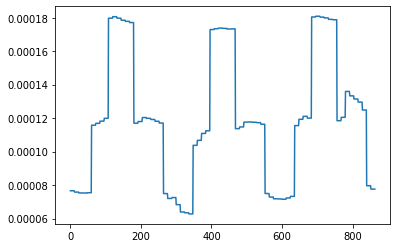

In [31]:
elect_price = np.array(data_frame.loc[1:3,:]) #  3 days electricity price
elect_price = np.repeat(elect_price, 12)
elect_price = elect_price/1e3
plt.plot(elect_price)

In [35]:
##############################################################
###   Simulation for a certain time period
##############################################################
def simulation(dH_simu, dH_flexi, iteration):
    weather = "CH_VD_Lausanne"
    env = energym.make("SimpleHouseRad-v0", weather=weather, simulation_days=10)
    np.random.seed(0)


    steps = 288*3 # simulation for 3 days
    out_list = []
    outputs = env.get_output() # get the output
    controls = []
    ti0 = outputs["temRoo.T"]
    elect_price = np.array(data_frame.loc[1:4,:])
    elect_price = np.repeat(elect_price, 12)
    elect_price = elect_price/1e3 # transform the unit of electricity price as cent/W

    u_local_real = np.array([]) # usage of local RES
    set_point = 21

    Gamma = np.array([])
    Gamma_new = np.array([])
    TIME = np.array([])

    ####  calculate_u_local(x0, tem_amb, sun_rad, set_point, w, u_bar, horizon):
    ####  optimal_control_wbar(ti_0, tem_amb, sun_rad, set_point, price, pre_hori, u_hat)
    ####  calculate_flexibility(x0, dhat, wbar, u_hat, horizon, flexi_start, flexi_horizon):
    flexi_start = 0
    flexi_horizon = 24 # compute the flexibility for one hour
    horizon = 144 # prediction horizon is 12 hours

    N_flexi = 24 # the prediction horizon for making assessment of flexibility is two hours

    w_nominal = np.zeros(steps+horizon)
    w_real = np.zeros(steps+horizon)
    
    Indicator = np.array([])

#     dH_simu = np.array([5,50]) ## this dH is for controlling the prediction error of exogenous input
#     dH_flexi = np.array([5,50])

    for t in range(steps):
        control = {}    
        ti_0 = outputs["temRoo.T"]
        u_hat = P_m[t:t+horizon] # u_hat: prediction of availability of local RES
        u_hat_RES = P_m[t:t+N_flexi]

        forecast = env.get_forecast(forecast_length = horizon)

        tem_amb_nominal = np.array(forecast["TOut.T"])
        sun_rad_nominal = np.array(forecast["sunRad.y"])

        ### prediction of future climate conditions
        
        tem_amb = tem_amb_nominal + dH_simu[0]#*(np.random.rand(horizon) - 0.5)*2
        sun_rad = sun_rad_nominal + dH_simu[1]#*(np.random.rand(horizon) - 0.5)*2


        price = elect_price[t:t+horizon]

        d_T = tem_amb[:N_flexi].reshape(-1,1)
        d_A = sun_rad[:N_flexi].reshape(-1,1)

        d = np.concatenate((d_T,d_A),axis = 1)
        dhat = d.reshape(-1)

        if t % 24 == 0:  # update the nominal power consumption from grid every one hour
            u_hat = P_m[t:t+horizon]
            wbar, _, _ = optimal_control_wbar(ti_0, tem_amb_nominal, sun_rad_nominal, set_point, price, horizon, u_hat)
            w_nominal[t:t+horizon] = np.array(wbar)
            w_real[t:t+horizon] = np.array(wbar)

#         print("wbar is calculated")
        if (t%24) == 0:   
            gamma1, gamma2, time_diff = calculate_flexibility_new_version2(np.array([ti_0]), dhat, wbar[:N_flexi], u_hat_RES, N_flexi, flexi_start, flexi_horizon,dH_flexi)
            Indicator = np.append(Indicator, 0)
            Gamma_new = np.append(Gamma_new, 0)
            
            if gamma1 <= 1:
                gamma1_new, gamma2_new, time_diff_new = calculate_flexibility_backup(np.array([ti_0]), dhat, wbar[:N_flexi], u_hat_RES, N_flexi, flexi_start, flexi_horizon,dH_flexi)                
                Indicator[-1] = 1
                Gamma_new[-1] = gamma1_new


            TIME = np.append(TIME, time_diff)
            
            ### generate demand response requests
            delta_w = np.zeros(flexi_horizon)
#            delta_w[0] = -np.random.rand()*gamma1
            
#             for k in range(1,flexi_horizon):
#                 delta_w[k] = np.minimum(np.maximum(delta_w[k-1] + 2*(np.random.rand() - 0.5)*gamma2, -gamma1),0)
                
            # delta_w = np.random.rand(flexi_horizon)*-gamma1
#             if (elect_price[t] >= 0.00015) & (elect_price[t+flexi_horizon] >= 0.00015):
#                 delta_w = np.ones(flexi_horizon) * -gamma1
            delta_w = -gamma1*(elect_price[t:t+flexi_horizon] >= 0.00015)
            
    
            w_real[t+flexi_start:t+flexi_start + flexi_horizon] += delta_w
            Gamma = np.append(Gamma, gamma1)
            
#             plt.plot(w_real[t:t+horizon])

        u_local = calculate_u_local(ti_0, tem_amb_nominal, sun_rad_nominal, set_point, w_real[t:t+horizon], u_hat, horizon)

        u_local_real = np.append(u_local_real, u_local)

        _u = (w_real[t] + u_local)/5000
        control['u'] = [_u]# + 0.25*(np.sin(i * 0.01 + np.random.rand()) + 1)]
        controls +=[ {p:control[p][0] for p in control} ] # each element is a dictionary
        outputs = env.step(control)
        _,hour,_,_ = env.get_date()
        hours.append(hour)
        out_list.append(outputs)
        
        print(t)
        
    out_sim = pd.DataFrame(out_list)
    roomT = np.array(out_sim["temRoo.T"].values - 273.13)
    filename = "simu_data" + str(iteration)
    np.savez(filename, Gamma = Gamma, roomT = roomT, w_nominal = w_nominal, w_real = w_real, u_res = u_local_real, Time = TIME, Indicator = 
            Indicator, Gamma_new = Gamma_new)
    



In [36]:
# # simulation with local RES
# dH_simulation = [np.array([0,0]), np.array([2,20]), np.array([5,50]), np.array([2,20]), np.array([5,50])]
# dH_flexibility = [np.array([0,0]), np.array([2,20]), np.array([5,50]), np.array([0,0]), np.array([0,0])]


# for i in range(4,5):
#     simulation(dH_simulation[i],dH_flexibility[i], i)
import time
import numpy as np
start = time.time()
end = time.time()
start - end
a = np.array([])
np.append(a,start)

array([1.66670589e+09])

In [37]:
# simulation without local RES
# change the range of the uncertainty
dH_simulation = [np.array([0,0]), np.array([2,50]), np.array([5,100]), np.array([2,50]), np.array([5,100])]
dH_flexibility = [np.array([0,0]), np.array([2,50]), np.array([5,100]), np.array([0,0]), np.array([0,0])]

for i in range(5):
    simulation(dH_simulation[i],dH_flexibility[i], i)

the initial variables are {'u': 0.0}
[OK] %s
[WARNING] %s
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262


120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
    model.name="unknown";
      - termination condition: infeasibleOrUnbounded
      - message from solver: Problem proven to be infeasible or unbounded.
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
    containing a solution
    model.name="unknown";
      - termination condition: infeasibleOrUnbounded
      - message from solver: Problem proven to be infeasible or unbounded.
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
28

525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774


In [87]:
xlable = np.linspace(0,24*day,frequency*day, endpoint = False)
xlable

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
       26., 28., 30., 32., 34., 36., 38., 40., 42., 44., 46., 48., 50.,
       52., 54., 56., 58., 60., 62., 64., 66., 68., 70.])

results for iteration:  0
the total flexibility capacity is:  31355.03024194374
the total temperature deviration is:  537.1223417255565
the total temperature deviration square is:  400.2879258272561
results for iteration:  1
the total flexibility capacity is:  29853.316645887302
the total temperature deviration is:  528.2987514671659
the total temperature deviration square is:  387.9744645314737
results for iteration:  2
the total flexibility capacity is:  16789.31283909098
the total temperature deviration is:  508.5053409769784
the total temperature deviration square is:  365.37358787954724
results for iteration:  3
the total flexibility capacity is:  41543.853300413386
the total temperature deviration is:  634.410620775022
the total temperature deviration square is:  596.6393530747616
results for iteration:  4
the total flexibility capacity is:  52232.40083240539
the total temperature deviration is:  670.6662453780407
the total temperature deviration square is:  793.7505466807778


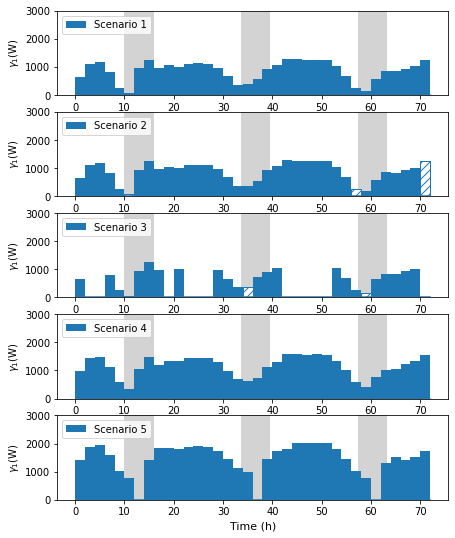

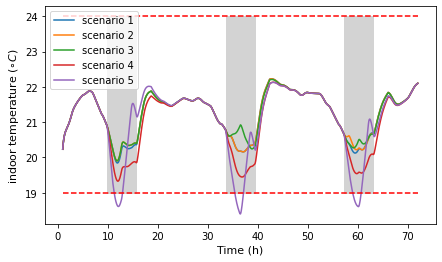

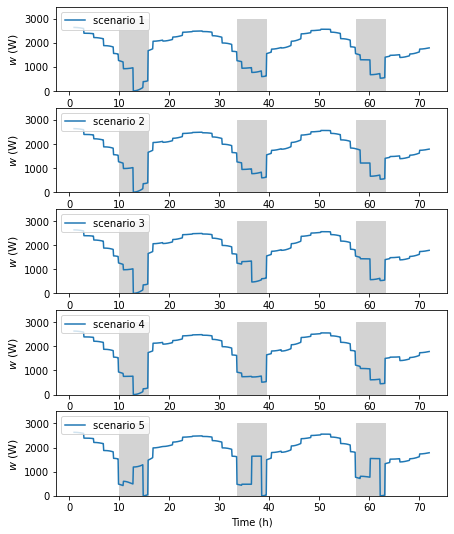

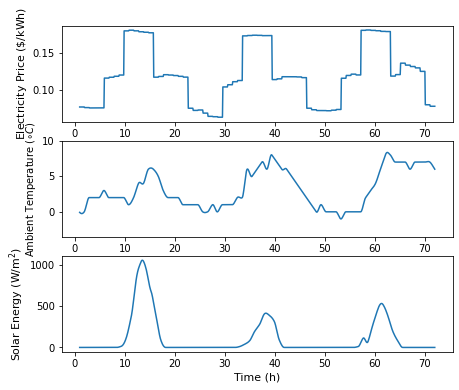

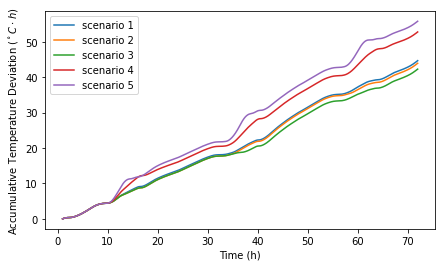

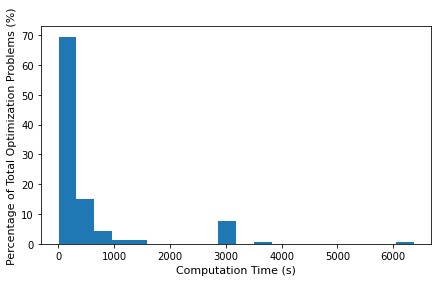

In [92]:
##########################################################
### Simulation results with RES
##########################################################
day = 3
frequency = 12
xlable_dense = np.linspace(1,24*day,288*day)


GAMMA = np.zeros((5,frequency*day))
GAMMA_new = np.zeros((5,frequency*day))
ROOMT = np.zeros((5,288*day))
W_NOMINAL = np.zeros((5,288*day+144))
W_REAL = np.zeros((5,288*day+144))
U_RES = np.zeros((5,288*day))
TIME = np.zeros((5,frequency*day))
Indicator = np.zeros((5, frequency*day))
for i in range(5):
    with np.load("simu_data"+str(i)+".npz") as data:
        GAMMA[i,:] = data["Gamma"]
        ROOMT[i,:] = data["roomT"]
        W_NOMINAL[i,:] = data["w_nominal"]
        W_REAL[i,:] = data["w_real"]
        U_RES[i,:] = data["u_res"]
        TIME[i,:] = data["Time"]
        GAMMA_new[i,:] = data["Gamma_new"]
        Indicator[i,:] = data["Indicator"]
        
TIME_all = TIME.reshape(1,-1)
        
GAMMA_final = np.zeros((5,frequency*day))
for i in range(5):
    for t in range(frequency*day):
        GAMMA_final[i,t] = GAMMA[i,t]

fontsize = 11
bar_width = 2

xlable = np.linspace(0,24*day,frequency*day, endpoint = False)

### figure for flexibility amount
plt.figure(figsize =(7,9))

plt.subplot(511)
plt.plot(xlable_dense, 0*np.ones(xlable_dense.shape[0]))
plt.fill_between(xlable_dense, 0, 3000, where = (elect_price[:288*day] >= 0.00015), color='lightgray')

p1 = plt.bar(xlable, GAMMA_final[0,:], width = bar_width, align = "edge")
p2 = plt.bar(xlable, GAMMA_new[0,:], width = bar_width, align = "edge", color = "w", edgecolor = "C0", hatch = "///")

plt.ylim([0,3000])
plt.legend([p1,p2], ["Scenario 1"], loc = 2)
plt.ylabel("$\gamma_1$(W)")


plt.subplot(512)
plt.plot(xlable_dense, 0*np.ones(xlable_dense.shape[0]))
plt.fill_between(xlable_dense, 0, 3000, where = (elect_price[:288*day] >= 0.00015), color='lightgray')

p1 = plt.bar(xlable, GAMMA_final[1,:], width = bar_width, align = "edge")
p2 = plt.bar(xlable, GAMMA_new[1,:], width = bar_width, align = "edge", color = "w", edgecolor = "C0", hatch = "///")
#plt.bar(xlable, Indicator[1,:]*3000, width = bar_width - 1, align = "edge")
# plt.fill_between(xlable_dense, 19, 24, where = (elect_price[:288*day] >= 0.00015), color='lightgray')

plt.ylim([0,3000])
plt.legend([p1],["Scenario 2"], loc = 2)
plt.ylabel("$\gamma_1$(W)")

plt.subplot(513)
plt.plot(xlable_dense, 0*np.ones(xlable_dense.shape[0]))
plt.fill_between(xlable_dense, 0, 3000, where = (elect_price[:288*day] >= 0.00015), color='lightgray')

p1 = plt.bar(xlable, GAMMA_final[2,:], width = bar_width, align = "edge")
p2 = plt.bar(xlable, GAMMA_new[2,:], width = bar_width, align = "edge", color = "w", edgecolor = "C0", hatch = "///")
# plt.fill_between(xlable_dense, 19, 24, where = (elect_price[:288*day] >= 0.00015), color='lightgray')
plt.ylim([0,3000])

plt.legend([p1], ["Scenario 3"], loc = 2)
plt.ylabel("$\gamma_1$(W)")

plt.subplot(514)
plt.plot(xlable_dense, 0*np.ones(xlable_dense.shape[0]))
plt.fill_between(xlable_dense, 0, 3000, where = (elect_price[:288*day] >= 0.00015), color='lightgray')

p1 = plt.bar(xlable, GAMMA_final[3,:], width = bar_width, align = "edge")
p2 = plt.bar(xlable, GAMMA_new[3,:], width = bar_width, align = "edge", color = "w", edgecolor = "C0", hatch = "///")

plt.ylim([0,3000])

plt.legend([p1], ["Scenario 4"], loc = 2)
plt.ylabel("$\gamma_1$(W)")

plt.subplot(515)
plt.plot(xlable_dense, 0*np.ones(xlable_dense.shape[0]))
plt.fill_between(xlable_dense, 0, 3000, where = (elect_price[:288*day] >= 0.00015), color='lightgray')

p1 = plt.bar(xlable, GAMMA_final[4,:], width = bar_width, align = "edge")
p2 = plt.bar(xlable, GAMMA_new[4,:], width = bar_width, align = "edge", color = "w", edgecolor = "C0", hatch = "///")

plt.ylim([0,3000])

plt.legend([p1], ["Scenario 5"], loc = 2)
plt.ylabel("$\gamma_1$(W)")

plt.xlabel("Time (h)", fontsize = fontsize)
plt.savefig("flexibility_amount.pdf", bbox_inches = "tight", pad_inches = 0.0)


#### figure for indoor temperture
xlable_dense = np.linspace(1,24*day,288*day)


plt.figure(figsize = (7,4))
plt.plot(xlable_dense, ROOMT.T[:288*day,:])
plt.legend(["scenario 1","scenario 2","scenario 3","scenario 4", "scenario 5"],loc=2)
plt.plot(xlable_dense, 19*np.ones(288*day), "--r")
plt.plot(xlable_dense, 24*np.ones(288*day), "--r")
 
plt.fill_between(xlable_dense, 19, 24, where = (elect_price[:288*day] >= 0.00015), color='lightgray')
plt.xlabel("Time (h)", fontsize = fontsize)
plt.ylabel("indoor temperature ($\circ C$)", fontsize = fontsize)

plt.savefig("indoor_temp.pdf", bbox_inches = "tight", pad_inches = 0.0)



##### figure for power drawn from the grid

plt.figure(figsize = (7,9))
plt.subplot(511)
plt.plot(xlable_dense, W_REAL[0,:288*day])
# plt.plot(xlable_dense, W_NOMINAL[0,:288*3])
plt.ylim([0,3500])
plt.fill_between(xlable_dense, 0, 3000, where = (elect_price[:288*day] >= 0.00015), color='lightgray')
plt.ylabel("${w}$ (W)", fontsize = fontsize)
#plt.ylabel("Power From Grid (W)", fontsize = fontsize)
plt.legend(["scenario 1"], loc = 2)

plt.subplot(512)
plt.plot(xlable_dense, W_REAL[1,:288*day])
# plt.plot(xlable_dense, W_NOMINAL[1,:288*3])
plt.fill_between(xlable_dense, 0, 3000, where = (elect_price[:288*day] >= 0.00015), color='lightgray')
plt.ylim([0,3500])
plt.ylabel("${w}$ (W)", fontsize = fontsize)
#plt.ylabel("Power From Grid (W)", fontsize = fontsize)
plt.legend(["scenario 2"], loc = 2)

plt.subplot(513)
plt.plot(xlable_dense, W_REAL[2,:288*day])
plt.fill_between(xlable_dense, 0, 3000, where = (elect_price[:288*day] >= 0.00015), color='lightgray')
# plt.plot(xlable_dense, W_NOMINAL[2,:288*3])
plt.ylim([0,3500])
plt.ylabel("${w}$ (W)", fontsize = fontsize)
#plt.ylabel("Power From Grid (W)", fontsize = fontsize)
plt.legend(["scenario 3"], loc = 2)

plt.subplot(514)
plt.plot(xlable_dense, W_REAL[3,:288*day])
plt.fill_between(xlable_dense, 0, 3000, where = (elect_price[:288*day] >= 0.00015), color='lightgray')
# plt.plot(xlable_dense, W_NOMINAL[3,:288*3])
plt.ylim([0,3500])
plt.ylabel("${w}$ (W)", fontsize = fontsize)
#plt.ylabel("Power From Grid (W)", fontsize = fontsize)
plt.legend(["scenario 4"], loc =2)

plt.subplot(515)
plt.plot(xlable_dense, W_REAL[4,:288*day])
plt.fill_between(xlable_dense, 0, 3000, where = (elect_price[:288*day] >= 0.00015), color='lightgray')
# plt.plot(xlable_dense, W_NOMINAL[4,:288*3])         
plt.ylim([0,3500])
plt.ylabel("${w}$ (W)", fontsize = fontsize)
#plt.ylabel("Power From Grid (W)", fontsize = fontsize)
plt.legend(["scenario 5"], loc =2)
plt.xlabel("Time (h)")
plt.savefig("real_power.pdf", bbox_inches = "tight", pad_inches = 0.0)


#### figure for electricity price, ambient temperature, solar energy
plt.figure(figsize = (7,6))
plt.subplot(311)
plt.plot(xlable_dense, elect_price[:288*day]*1000)
plt.ylabel("Electricity Price ($\$$/kWh)", fontsize = fontsize)

plt.subplot(312)
plt.plot(xlable_dense, T_out[:288*day] - 273.15)
plt.ylabel("Ambient Temperature ($\circ C$)")
plt.ylim([-3.5,10])

plt.subplot(313)
plt.plot(xlable_dense, P_m[:288*day])
plt.ylabel("Solar Energy (W/m$^2$)", fontsize = fontsize)
plt.xlabel("Time (h)", fontsize = fontsize)

plt.savefig("price_solar.pdf", bbox_inches = "tight", pad_inches = 0.0)


# plt.figure(figsize = (7,10))

# plt.subplot(511)
# plt.plot(xlable_dense, U_RES[0,:])
# plt.plot(xlable_dense, P_m[:288*day])
# plt.ylim([0, 1500])

# plt.subplot(512)
# plt.plot(xlable_dense, U_RES[1,:])
# plt.ylim([0, 1500])

# plt.subplot(513)
# plt.plot(xlable_dense, U_RES[2,:])
# plt.plot(xlable_dense, P_m[:288*day])
# plt.ylim([0, 1500])

# plt.subplot(514)
# plt.plot(xlable_dense, U_RES[3,:])
# plt.ylim([0, 1500])

# plt.subplot(515)
# plt.plot(xlable_dense, U_RES[4,:])
# plt.ylim([0, 1500])


# plt.figure()
# plt.plot(xlable_dense, U_RES[0,:] + W_REAL[0,:288*day])
# plt.figure(figsize = (9,6))
# plt.subplot(411)
# plt.plot(W_NOMINAL.T[:288*3,:])
# plt.legend(["0","1","2","3","4"])
# plt.subplot(412)
# plt.plot(W_REAL.T[:288*3,:])
# plt.legend(["0","1","2","3","4"])
# plt.subplot(413)
# plt.plot(elect_price[:288*3])
# plt.subplot(414)
# plt.plot(P_m[:288*3])

temp_diff = np.abs(ROOMT - 21)
temp_diff_new = np.zeros(ROOMT.shape)
for i in range(temp_diff_new.shape[0]):
    for j in range(temp_diff_new.shape[1]):
        temp_diff_new[i,j] = np.sum(temp_diff[i,:j])

#### figure for indoor temperature deviation
plt.figure(figsize = (7,4))
plt.plot(xlable_dense, temp_diff_new.T[:288*day,:]/12)
plt.legend(["scenario 1","scenario 2","scenario 3","scenario 4", "scenario 5"])
plt.xlabel("Time (h)")
plt.ylabel("Accumulative Temperature Deviation ($^\circ C\cdot h$)")
plt.savefig("temp_diff.pdf", bbox_inches = "tight", pad_inches = 0.0)

#### figure for percentage of computation time
counts, bins = np.histogram(TIME_all, bins = 20)
plt.figure(figsize = (7,4))
plt.stairs(counts/np.sum(counts)*100, bins, fill = True)
plt.xlabel("Computation Time (s)", fontsize = 11)
plt.ylabel("Percentage of Total Optimization Problems (%)", fontsize = 11)
plt.savefig("percentage.pdf", bbox_inches = "tight", pad_inches = 0.0)


for i in range(5):
    print("results for iteration: ", i)
    print("the total flexibility capacity is: ", np.sum(GAMMA[i,:]))
    print("the total temperature deviration is: ", np.sum(np.abs(ROOMT[i,:] - 21)))
    print("the total temperature deviration square is: ", np.sum((ROOMT[i,:] - 21)**2))

In [81]:
GAMMA_new[2,-1]

0.0

In [ ]:
GAMMA_new[1,:]

In [ ]:
Indicator[2,:]

In [ ]:
###################################################################
### Simulation results without RES
###################################################################
GAMMA = np.zeros((5,12*3))
ROOMT = np.zeros((5,288*3))
W_NOMINAL = np.zeros((5,288*3+144))
W_REAL = np.zeros((5,288*3+144))

for i in range(5):
    with np.load("simu_data_noRES"+str(i)+".npz") as data:
        GAMMA[i,:] = data["Gamma"]
        ROOMT[i,:] = data["roomT"]
        W_NOMINAL[i,:] = data["w_nominal"]
        W_REAL[i,:] = data["w_real"]
        

        
plt.figure(figsize = (7,6))
plt.subplot(211)
plt.plot(GAMMA.T)
plt.legend(["0","1","2","3","4"])
plt.subplot(212)
plt.plot(ROOMT.T[:288*3,:])
plt.legend(["0","1","2","3","4"])

plt.figure(figsize = (10,10))
plt.subplot(411)
plt.plot(W_NOMINAL.T[:288*3,:])
plt.legend(["0","1","2","3","4"])
plt.subplot(412)
plt.plot(W_REAL.T[:288*3,:])
plt.legend(["0","1","2","3","4"])
plt.subplot(413)
plt.plot(elect_price[:288*3])
plt.subplot(414)
plt.plot(P_m[:288*3])

for i in range(5):
    print("results for iteration: ", i)
    print("the total flexibility capacity is: ", np.sum(GAMMA[i,:]))
    print("the total temperature deviration is: ", np.sum(np.abs(ROOMT[i,:] - 22)))

In [ ]:
# with np.load("data_without_uncertain.npz") as data_non: ## without considering uncertainties both in design and simulation
#     Gamma_non = data_non["Gamma"]
#     roomT_non = data_non["roomT"]
#     w_nominal_non = data_non["w_nominal"]
#     w_real_non = data_non["w_real"]

    
# with np.load("data_with_uncertain_nonzero.npz") as data: ## considering uncertainties both in design and simulation
#     Gamma = data["Gamma"]
#     roomT = data["roomT"]
#     w_nominal = data["w_nominal"]
#     w_real = data["w_real"]
    
# with np.load("data_with_uncertain_nonzero2.npz") as data: ## considering uncertainties only in simulation
#     Gamma2 = data["Gamma"]
#     roomT2 = data["roomT"]
#     w_nominal2 = data["w_nominal"]
#     w_real2 = data["w_real"]
    
# plt.figure()
# plt.subplot(211)
# plt.plot(Gamma_non)
# plt.plot(Gamma)
# plt.plot(Gamma2)
# plt.legend(["without", "with", "with2"])
# plt.subplot(212)
# plt.plot(P_m[:288])

# plt.figure(figsize=(5,10))
# plt.subplot(311)
# plt.plot(roomT_non)
# plt.plot(roomT)
# plt.plot(roomT2)
# plt.legend(["without", "with", "with2"])

# plt.subplot(312)
# plt.plot(w_nominal_non[:288])
# plt.plot(w_nominal[:288])
# plt.plot(w_nominal2[:288])
# plt.legend(["without", "with", "with2"])

# plt.subplot(313)
# plt.plot(w_real_non[:288])
# plt.plot(w_real[:288])
# plt.plot(w_real2[:288])
# plt.legend(["without", "with", "with2"])
    
# print("\nthe accumulated flexibility for without is: ", np.sum(Gamma_non))
# print("\nthe accumulated flexibility for without is: ", np.sum(Gamma))
# print("\nthe accumulated flexibility for without is: ", np.sum(Gamma2))

In [ ]:
plt.figure(figsize =(6,4))
plt.subplot(211)
plt.plot(time, w_nominal, "g")
plt.ylim([0,4200])
plt.legend(["nominal power"])
plt.ylabel("power")
plt.subplot(212)
plt.plot(time, w, "r")
plt.ylim([0,4200])
plt.legend(["power with flexibility"])
plt.xlabel("time (h)")
plt.ylabel("power")
plt.savefig("power_consump.pdf")

plt.figure()
plt.subplot(211)
# out_sim_nominal["temRoo.T"].values
plt.plot(time, np.array(x_nominal) - 273.15, "g")
plt.ylim([19,25])
plt.ylabel("temperature")
plt.legend(["room T (nominal prediction)"])
plt.subplot(212)
plt.plot(time, out_sim["temRoo.T"].values - 273.13, "r")
plt.ylim([19,25])
plt.ylabel("temperature")
plt.legend(["room T (with flexibility)"])

plt.xlabel("time (h)")
plt.savefig("room_T.pdf")
           

In [ ]:
prediction_horizon  = 288
forecast = env.get_forecast(forecast_length = prediction_horizon)
w_nominal = optimal_control_wbar(outputs["temRoo.T"], forecast["TOut.T"], forecast["sunRad.y"], 22, price, prediction_horizon)

plt.subplot(211)
plt.plot(w_nominal)
plt.title("wbar and price signal")
plt.subplot(212)
plt.plot(price)

In [ ]:
wbar = optimal_control_wbar(outputs["temRoo.T"], forecast["TOut.T"], forecast["sunRad.y"], 22, price, prediction_horizon)

In [ ]:
weather = "CH_BS_Basel"
env = energym.make("SimpleHouseRad-v0", weather=weather, simulation_days=20)
from scipy import signal

steps = 288

out_list = []
outputs = env.get_output()
controls = []
hour = 0
hours = []
set_point = np.zeros(1000)

for i in range(500):
    set_point[i] = 22 + 2*signal.square(0.05*i)


for i in range(steps):
    control = {} 
    forecast = env.get_forecast(forecast_length = pre_hori)
    _u = optimal_control(outputs["temRoo.T"], forecast["TOut.T"], forecast["sunRad.y"], set_point[i:i+pre_hori])    
    control['u'] = [_u]# + 0.25*(np.sin(i * 0.01 + np.random.rand()) + 1)]
    controls +=[ {p:control[p][0] for p in control} ] # each element is a dictionary
    outputs = env.step(control)
    _,hour,_,_ = env.get_date()
    hours.append(hour)
    out_list.append(outputs)

In [ ]:
plt.plot(w[:N])
plt.plot(wbar[:N])

In [ ]:
steps = 288
out_list = []
outputs = env.get_output()
controls = []
hours = []
weather = "CH_BS_Basel"
env = energym.make("SimpleHouseRad-v0", weather=weather, simulation_days=1)
for i in range(steps):
    control = {} 
    _u = w[i]/5000
    control['u'] = [_u]
    controls +=[ {p:control[p][0] for p in control} ] # each element is a dictionary
    outputs = env.step(control)
    _,hour,_,_ = env.get_date()
    hours.append(hour)
    out_list.append(outputs)

In [ ]:
out_sim  = pd.DataFrame(out_list)
out_sim.shape
plt.subplot(211)
plt.plot(out_sim["temRoo.T"].values - 273.13)
plt.subplot(212)
plt.plot(price)

plt.figure()
plt.subplot(211)
plt.plot(w)
plt.subplot(212)
plt.plot(wbar)

In [ ]:
# simulation results for using MPC
pre_hori = 144 # prediction horizon 144*5 mins
import pyomo.environ as pyo
from pyomo.opt import SolverFactory

from pyomo.environ import *

## demo simulation for controlling room temperature around 22 degree
def optimal_control(ti_0, tem_amb, sun_rad, set_point):
    
### input: initial room temperature, ambient temperature prediction, sun radiation prediction
### output: MPC control input
    model = pyo.ConcreteModel()
    model.idx_x = range(pre_hori+1)
    model.idx = range(pre_hori)
    
    model.epsilon = pyo.Var(domain = pyo.PositiveReals)
    
    def x_bound_l(model, i):
        return 19 + 273.15 - model.epsilon <= model.x[i]
    
    def x_bound_u(model, i):
        return model.x[i] <= 24 + 273.15 + model.epsilon

    model.x = pyo.Var(model.idx_x)
    
    model.x_bound_l = pyo.Constraint(model.idx_x, rule = x_bound_l)
    model.x_bound_u = pyo.Constraint(model.idx_x, rule = x_bound_u)
    
    model.u = pyo.Var(model.idx, within = Boolean)
    

    def constraint_x(model,i):
        return model.x[i+1] == A*model.x[i] + B1*5000*3.73*model.u[i]/300 + np.dot(B2,np.array([tem_amb[i],sun_rad[i]]))
    model.cons_x = pyo.Constraint(model.idx, rule = constraint_x)
    
    model.cons_x0 = pyo.Constraint(expr = model.x[0] == ti_0)
    
    def Obj(model):
        return sum((model.x[i+1] - set_point[i] - 273.15)**2 for i in range(0,pre_hori)) + 100 * model.epsilon
    
    model.obj = pyo.Objective(sense = pyo.minimize, rule = Obj)
    
    opt = SolverFactory("ipopt")
    opt.solve(model)
    
    return model.u[0].value

In [ ]:
forecast = env.get_forecast(forecast_length = 24)
# forecast["TOut.T"]
# forecast["sunRad.y"]

In [ ]:
optimal_control(273.15 + 19, forecast["TOut.T"], forecast["sunRad.y"],0)

In [ ]:
weather = "CH_BS_Basel"
env = energym.make("SimpleHouseRad-v0", weather=weather, simulation_days=20)
from scipy import signal

steps = 288

out_list = []
outputs = env.get_output()
controls = []
hour = 0
hours = []
set_point = np.zeros(1000)

for i in range(500):
    set_point[i] = 22 + 2*signal.square(0.05*i)


for i in range(steps):
    control = {} 
    forecast = env.get_forecast(forecast_length = pre_hori)
    _u = optimal_control(outputs["temRoo.T"], forecast["TOut.T"], forecast["sunRad.y"], set_point[i:i+pre_hori])    
    control['u'] = [_u]# + 0.25*(np.sin(i * 0.01 + np.random.rand()) + 1)]
    controls +=[ {p:control[p][0] for p in control} ] # each element is a dictionary
    outputs = env.step(control)
    _,hour,_,_ = env.get_date()
    hours.append(hour)
    out_list.append(outputs)
#    print(f"iteration: {i}")

In [ ]:
out_sim  = pd.DataFrame(out_list)
out_sim.shape
plt.plot(out_sim["temRoo.T"].values - 273.13)
plt.plot(set_points,"r")
plt.legend(["simulation","set_point"], loc = 1)

In [ ]:
in_sim = pd.DataFrame(controls)
plt.plot(in_sim["u"].values)
plt.legend("u")

In [ ]:
out_sim  = pd.DataFrame(out_list)
out_sim.shape

plt.plot(out_sim["temRoo.T"].values - 273.13)
plt.plot(set_points,"r")
plt.legend(["simulation","set_point"])

In [ ]:
in_sim = pd.DataFrame(controls)
plt.plot(in_sim["u"].values)
plt.legend("u")